In [1]:
import json

import pandas as pd
import matplotlib.pyplot as plt

from notebook_client.notebook_client import NotebookClient

In [6]:
nc = NotebookClient()
nc.initialize_producers_manager_connection()
nc.initialize_sampler_manager_connection()

In [7]:
producer_pid = nc.start_streaming('in_topic', { 'locations': '-74,40,-73,41' })

In [8]:
reservoir_size = 5
limit = 20
nc.start_sampling('in_topic', 'out_topic', reservoir_size, limit)

In [5]:
nc.streaming_status(producer_pid)

'running'

In [10]:
nc.sampling_status()

'finished'

In [11]:
nc.stop_streaming(producer_pid)

'stopped'

In [12]:
from kafka import KafkaConsumer

consumer = KafkaConsumer('out_topic', bootstrap_servers='kafka')
consumer.topics()
partition = consumer.assignment().pop()

In [13]:
consumer.seek_to_end()

In [14]:
end = consumer.position(partition)
consumer.seek(partition, end - reservoir_size)

In [15]:
consumer.position(partition)

5

In [16]:
get_value = lambda c: c.__next__().value.decode('utf-8')
data = [get_value(consumer) for i in range(reservoir_size)]

In [17]:
parsed_data = list(map(lambda x: json.loads(x), data))

In [18]:
df = pd.DataFrame.from_records(data=parsed_data)
df['created_at'] = pd.to_datetime(df['created_at'])
df.index = df.created_at
del df['created_at']

In [19]:
df

,text,user_favourites_count,user_friends_count,user_id,user_name,user_verified
created_at,,,,,,
2017-08-02 16:35:40,I'm still smiling from this interview https://...,2807,852,393575726,Dan Mannarino,True
2017-08-02 16:35:41,Can you recommend anyone for this #job in #New...,0,268,118562262,TMJ-NYC Security Job,False
2017-08-02 16:35:41,"Want to work at Atlas Air, Inc? We're #hiring ...",0,120,558786089,Ramapo Aviation,False
2017-08-02 16:35:43,I love how literally everyone in my family cal...,55359,466,834762050,❦ ¢няιѕтιηα ❦,False
2017-08-02 16:35:47,I'm at Foursquare HQ - @foursquareguide in New...,0,81,182481536,Ravi Jung Karki,False


In [20]:
df.describe()

,user_favourites_count,user_friends_count,user_id
count,5.000000,5.000000,5.000000e+00
mean,11633.200000,357.400000,4.176335e+08
std,24473.666556,315.107601,2.912212e+08
min,0.000000,81.000000,1.185623e+08
25%,0.000000,120.000000,1.824815e+08
50%,0.000000,268.000000,3.935757e+08
75%,2807.000000,466.000000,5.587861e+08
max,55359.000000,852.000000,8.347620e+08


In [21]:
#text_lengths = df.text.map(lambda x: len(x.split(' ')))
text_lengths = df.text.map(len)

In [22]:
text_lengths.describe()

count      5.000000
mean      85.000000
std       28.416544
min       60.000000
25%       61.000000
50%       79.000000
75%       97.000000
max      128.000000
Name: text, dtype: float64

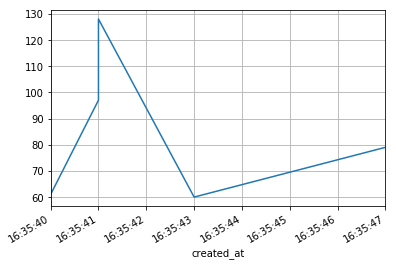

In [23]:
text_lengths.plot(grid=True)
plt.show()

In [24]:
import pyspark

sc = pyspark.SparkContext('local[*]')
sqlc = pyspark.sql.SQLContext(sc)

In [25]:
spark_df = sqlc.createDataFrame(df)

In [26]:
import pyspark.mllib.regression as mllib_reg
import pyspark.mllib.linalg as mllib_lalg
import pyspark.mllib.classification as mllib_class

In [27]:
data_labeled = spark_df.rdd.map(lambda fields: mllib_reg.LabeledPoint(fields[-1], mllib_lalg.Vectors.dense(fields[2:4])))

In [28]:
train, test = data_labeled.randomSplit([0.65, 0.35], seed = 13)

In [29]:
nbay = mllib_class.NaiveBayes.train(train, 1.0)

In [30]:
predictionAndLabel = test.map(lambda p : (nbay.predict(p.features), p.label))

In [31]:
testErr = predictionAndLabel.filter(lambda x: x[0] != x[1]).count() / test.count()
accuracy = 100.0 * predictionAndLabel.filter(lambda x: x[0] == x[1]).count() / test.count()

In [32]:
print('Accuracy: {0}%'.format(accuracy))

Accuracy: 50.0%


In [33]:
nbay